In [50]:
import os
import cv2
import difflib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
from PIL import Image
from tensorflow import keras
from google.colab import drive
from scipy import stats, spatial
from keras.layers import Dropout
from scipy.stats import ks_2samp, kendalltau
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import defaultdict
from datetime import datetime



drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Image_processing/Yossi')


# images and folders paths
IMAGE_PATH = 'all_include/try_4/צילום מסך 2021-02-24 100947.png'
XML_PATH = 'all_include/try_4/צילום מסך 2021-02-24 100947.xml'
#IMAGE_PATH = "camera/WhatsApp Image 2021-03-07 at 18.06.04.jpeg"
#XML_PATH = 'camera/WhatsApp Image 2021-03-07 at 18.06.04.xml'
#IMAGE_PATH = "camera/WhatsApp Image 2021-03-07 at 18.08.15.jpeg"
#XML_PATH = 'camera/WhatsApp Image 2021-03-07 at 18.08.15.xml'

BACKGROUND_IMAGE_PATH = "background.png"
TRAIN_DATA_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/train/"
TEST_DATA_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/"
FREE_TEST_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/empty/spot490.jpg"
CAR_TEST_PATH = "/content/drive/MyDrive/Image_processing/Yossi/train_data/test/occupied/spot115.jpg"

CAR_VAL = 1
FREE_VAL = 0
CAR_COLOR = 'g'
FREE_COLOR = 'r'
CAR_LABEL = 'car'
FREE_LABEL = 'free'

# change detection functions names
MSE = 'MSE'
CHANGE_DETECTION = 'change_dection'
VAR_DETECTION = 'var_change_detection'
COSINE_CHANGE_DETECTION = 'cosine_change_detection'
SEQUENCE_MATCHER = 'sequence_matcher'
CLASSIFIER = 'predictImage'
KENDALL = 'kendal'
ABS = 'absdiff'
HISTOGRAM = "histogram"


EVAL_LIST = [MSE, CHANGE_DETECTION, VAR_DETECTION, COSINE_CHANGE_DETECTION, CLASSIFIER, KENDALL, ABS, HISTOGRAM]

# change detection functions thresholds
CHANGE_DETECTION_THRESHOLD_1 = 3 
CHANGE_DETECTION_THRESHOLD_2 = 1
MSE_THRESHOLD = 10000
VAR_THRESHOLD = 1000
COSINE_THRESHOLD = -0.35
SEQUENCE_THRESHOLD = 0.2
KENDAL_THRESHOLD = 0.25
ABS_THRESHOLD_1 = 100
ABS_THRESHOLD_2 = 50

# classification model constants
INPUT_SHAPE = 60
BATCH_SIZE = 8
CLASS_MODE = 'binary'
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
EPOCHS = 10
STEPS_PER_EPOCH = 16
METRICS = ['accuracy']
DROPOUT_1 = 0.2
DROPOUT_2 = 0.5
CLASSIFIER_THRESHOLD = 0.5
LAYER_1_SIZE = 32
LAYER_2_SIZE = 64
LAYER_3_SIZE = 128
LAYER_4_SIZE = 256
LAYER_5_SIZE = 512
CONV_SIZE = (3,3)
ACTIVATION_FUNC = 'relu'
LAST_ACTIVATION_FUNC = 'sigmoid'
MAX_POOL = 2
PIXEL_COLORS = 3
RESCALE = 1/255
FONT_SIZE = 30
SAVED_MODEL_PATH = 'parking_lot_model.h5'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Parse the xml that contains the parking lot data:


Each object contains it label(free/occupied) and 4 cordinats: x_min, x_max, y_min, y_max.

We're created that xml using "labelImg" tool: 
https://github.com/tzutalin/labelImg
(all we needed is to insert an image and assign the parking lots as a rectangles, the tool creates xml that contains the rectangle coordinates and their labels.) 


In [18]:
# create a list that contains the parking lots objects(cordonates and labels)
root = ET.parse(XML_PATH).getroot()

all_obj = list()
for el in root.findall('object'):
    current = dict()
    for ch in el.getchildren():
        if ch.tag == 'bndbox':
          for el in ch.getchildren():
            current[el.tag] = int(el.text)
        elif ch.tag == 'name':
          current['label'] = ch.text
    all_obj.append(current)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  if __name__ == '__main__':


In [3]:
all_obj[:2]

[{'label': 'car', 'xmax': 738, 'xmin': 713, 'ymax': 131, 'ymin': 118},
 {'label': 'car', 'xmax': 913, 'xmin': 884, 'ymax': 117, 'ymin': 103}]

Our first approach is to take the parking lot image when it completly empty and compare the patches that represents each parking lot space of the given frame to the same location in the empty one.

In the second approach we'll calculate a "median" free parking lot patch from several free parking lot spaces.

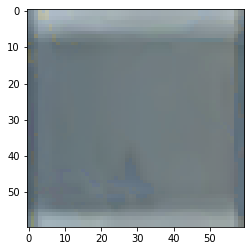

In [19]:
def get_patch_from_dict(obj, image):

  return image[obj["ymin"]:obj["ymax"], obj["xmin"]:obj["xmax"]]

def construct_free_patches(all_obj, image):
  patches_list = [get_patch_from_dict(elem, image) for elem in all_obj if elem['label'] == 'free']
  for i in range(len(patches_list)):
    patches_list[i] = cv2.resize(patches_list[i], (INPUT_SHAPE, INPUT_SHAPE)) 
    #fig,ax = plt.subplots(1)
  return patches_list

def get_background_img(images_list):
    '''
    Calculate the background_img by getting the median pixel
    from the sum's list of pixel in each k1 imgs 
    '''

    background_img = np.zeros_like(images_list[0])
    for i in range(len(background_img)): # row
        for j in range(len(background_img[0])): # colomn
            
            colors_sum_list = [(ix, sum(img[i][j])) for ix, img in enumerate(images_list)]
            colors_sum_list.sort(key=lambda tup: tup[1])
            median_index = colors_sum_list[int(len(colors_sum_list)/2)]
            background_img[i][j] = images_list[median_index[0]][i][j]


    return background_img

im = IMAGE_PATH
image = np.array(Image.open(im), dtype=np.uint8)[:, :, :3]
images_list = construct_free_patches(all_obj, image)
background_img = get_background_img(images_list[4:10])

fig,ax = plt.subplots(1)
ax.imshow(background_img)

Plot the object cordinate as a rectanlge (for visual only)

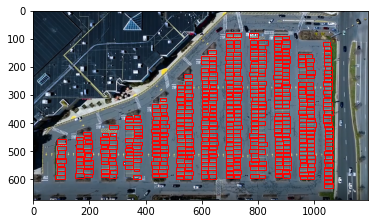

In [20]:
im = BACKGROUND_IMAGE_PATH
image = np.array(Image.open(im), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(image)
for elem in all_obj:
  
  xmin = elem['xmin']
  ymin = elem['ymin']
  xmax = elem['xmax']
  ymax = elem['ymax']

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
  
  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In order to use Deep learning we were training a binary classification model using Keras(A CNN one).
We're cutting empty and occupied parking lots from the video's frames and split them into train and test, created a model and saved it to a file.

So, we need to loading it in order to make predictions:


In [21]:
model = keras.models.load_model(SAVED_MODEL_PATH)


Now we'll implement few methods in order to compare between patches:

1. Mean Squared Error
2. Median change dection
3. Variance comparison
4. Cosine similarity
5. Sequence Matcher
6. Histogram comparing

we'll also create a method that get a patch and predict if it belong to a free/occupied class using our classification model

In [22]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return 0 if err < MSE_THRESHOLD else 1
  
def change_dection(background_img, img, threshold=120):
    
    counts = 0 
                
    for i in range(len(img)): # row
        for j in range(len(img[0])): # colomn
            
            count = 0 
            for c in range(len(img[0][0])): # colomn

                dist = abs(int(img[i][j][c]) - int(background_img[i][j][c]))
                #print(dist)
                if dist > threshold:
                    count += 1

            if count == CHANGE_DETECTION_THRESHOLD_1:
                counts += 1
    if counts > CHANGE_DETECTION_THRESHOLD_2:      
      return 1
    else:
      return 0


def var_change_detection(background_img, img):
    
    return 0 if img.var() < VAR_THRESHOLD else 1


def cosine_change_detection(background_img, img):

    result = spatial.distance.cosine(background_img, img)
    return 0 if result < COSINE_THRESHOLD else 1


def sequence_matcher(background_img, img):

    result = difflib.SequenceMatcher(None,background_img,img)
    return 0 if result.ratio() > SEQUENCE_THRESHOLD else 1


def kendal(background_img, img):

    tau, p_value = kendalltau(background_img,img)
    return 0 if abs(tau) > KENDAL_THRESHOLD else 1

def absdiff(back_image, img):

    dif = cv2.absdiff(back_image, img)
    thresholded = cv2.threshold(dif, ABS_THRESHOLD_1, 255, cv2.THRESH_BINARY)[1]
    return 0 if np.count_nonzero(thresholded) < ABS_THRESHOLD_2 else 1

def predictImage(img1):
    """
    Get a image and predicting it label 
    """
    Y = cv2.resize(img1, (INPUT_SHAPE, INPUT_SHAPE))    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    if val > CLASSIFIER_THRESHOLD:  
        return 1
    else:
        return 0



Now let create a prediction method which using the trained model above. 
We needed to pad the patches in order to predict the labels. 

Now we'll create 2 methods(one for each approach) that getting a patch of free parking lot and a patch and predict if it's frre/occupied. 

In [23]:
def predict_by_back_image(back_image, image, func_name, ymin, ymax, xmin, xmax):

    back_image_patch = back_image[ymin:ymax, xmin:xmax]
    image_patch = image[ymin:ymax, xmin:xmax]
    return get_res(back_image_patch, image_patch, func_name)

def predict_by_median_image(back_image, image, func_name, ymin, ymax, xmin, xmax):

    back_image_patch = back_image
    image_patch = cv2.resize(image[ymin:ymax, xmin:xmax], (INPUT_SHAPE, INPUT_SHAPE))

    return get_res(back_image_patch, image_patch, func_name)

def get_res(back_image_patch, image_patch, func_name):

    if func_name == MSE:
      result = mse(back_image_patch, image_patch)
    elif func_name == CHANGE_DETECTION:
      result = change_dection(back_image_patch, image_patch)
    elif func_name == VAR_DETECTION:
      result = var_change_detection(back_image_patch.flatten(), image_patch.flatten())
    elif func_name == COSINE_CHANGE_DETECTION:
      result = cosine_change_detection(back_image_patch.flatten(), image_patch.flatten())
    elif func_name == SEQUENCE_MATCHER:
      result = sequence_matcher(back_image_patch.flatten(), image_patch.flatten())
    elif func_name == CLASSIFIER:
      result = predictImage(image_patch)
    elif func_name == KENDALL:
      result = kendal(back_image_patch.flatten(), image_patch.flatten())
    elif func_name == ABS:
      dif = cv2.absdiff(back_image_patch, image_patch)
      thresholded = cv2.threshold(dif, 100, 255, cv2.THRESH_BINARY)[1]
      result = 0 if np.count_nonzero(thresholded) < 50 else 1
    elif func_name == HISTOGRAM:
      result = 1 if ks_2samp(back_image_patch.flatten(), image_patch.flatten())[0] > 0.25 else 0
    else:
      return 0
    return result

Now, we'll go over each parking lot space and detect the number of empty spaces using the implemented approaches and figure which is better for this task. 

Now, in order to evaluate the differents patch comparing elgorithms we'll use the knowns metrics Accuracy, Precision, Recall, F1 and determine which is better.

Accuracy - it’s the ratio of the correctly labeled subjects to the whole pool of subjects.

Precision - the fraction of retrieved documents that are relevant to the query.

Recall - the fraction of the relevant documents that are successfully retrieved.

F1 - a function of Precision and Recall, is needed when you want to seek a balance between Precision and Recall.

In [24]:
def model_analysis(all_obj):
  
  results = dict()
  y_actu = [0 if one_obj['label'] == 'free' else 1 for one_obj in all_obj]
  y_pred = [0 if one_obj['predicted'] == 'free' else 1 for one_obj in all_obj]

  results["accuracy_score"] = accuracy_score(y_actu, y_pred)
  results["precision_score"] = precision_score(y_actu, y_pred, average="macro")
  results["f1_score"] = f1_score(y_actu, y_pred, average="macro")
  results["recall_score"] = recall_score(y_actu, y_pred, average="macro")
  print(classification_report(y_actu, y_pred))   
  return results

Here, we implemented a function that getting the approach name and the comparissom method, plotting the predicted parking lot spaces and returns the evaluation results. 

The green rectangles represents the occupied parking lot spaces and red for free.

In [51]:


def run_all(compare_func_name, predict_func):

  start=datetime.now()

  if predict_func == predict_by_back_image:
    back_image = np.array(Image.open(BACKGROUND_IMAGE_PATH), dtype=np.uint8)[:, :, :3]
  else:
    back_image = background_img

  image = np.array(Image.open(IMAGE_PATH), dtype=np.uint8)[:, :, :3]
  fig,ax = plt.subplots(1)
  ax.imshow(image)
  empty = 0  
  for elem in all_obj:
    
    xmin = elem['xmin']
    ymin = elem['ymin']
    xmax = elem['xmax']
    ymax = elem['ymax']

    result = predict_func(back_image, image, compare_func_name, ymin, ymax, xmin, xmax)

    elem['predicted'] = CAR_LABEL if result == 1 else FREE_LABEL

    if result == CAR_VAL:
      rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor=CAR_COLOR,facecolor='none')
      
    else:
      rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor=FREE_COLOR,facecolor='none')
      empty += 1


    # Add the patch to the Axes
    ax.add_patch(rect)

  model_analysis_results = model_analysis(all_obj)
  model_analysis_results['running_time_seconds'] = (datetime.now()-start).total_seconds()

  plt.show()
  print(f'approach: {predict_func.__name__}')
  print(f'func: {compare_func_name}')
  print(f"Free parking lots: {empty}")
  print(f"running time in seconds: {model_analysis_results['running_time_seconds']}")
  print('-'* 100)

  return model_analysis_results
  


In [52]:
eval_dict = defaultdict(dict)

for predict_func in [predict_by_median_image, predict_by_back_image]:
  for eval_fnc in EVAL_LIST:
        eval_dict[predict_func.__name__][eval_fnc] = run_all(eval_fnc, predict_func)
        


Output hidden; open in https://colab.research.google.com to view.

In [53]:
eval_dict

defaultdict(dict,
            {'predict_by_back_image': {'MSE': {'accuracy_score': 0.9823182711198428,
               'f1_score': 0.9725137251372514,
               'precision_score': 0.9579439252336448,
               'recall_score': 0.9890510948905109,
               'running_time_seconds': 0.394516},
              'absdiff': {'accuracy_score': 0.9921414538310412,
               'f1_score': 0.987459965508746,
               'precision_score': 0.9837775061124694,
               'recall_score': 0.9912483241471771,
               'running_time_seconds': 0.406222},
              'change_dection': {'accuracy_score': 0.9155206286836935,
               'f1_score': 0.881052145322138,
               'precision_score': 0.8476767914606389,
               'recall_score': 0.9399175728685635,
               'running_time_seconds': 1.676213},
              'cosine_change_detection': {'accuracy_score': 0.7838899803536346,
               'f1_score': 0.5699692780337942,
               'precision_score

Creating a pandas dataframe from the results dict for both approaches:

In [63]:
import pandas as pd

#s = pd.DataFrame(eval_dict)[''].T
s_1 = pd.DataFrame(eval_dict['predict_by_median_image']).T
s_2 = pd.DataFrame(eval_dict['predict_by_back_image']).T

s_1.running_time_seconds = s_1.running_time_seconds.round(3)
s_2.running_time_seconds = s_1.running_time_seconds.round(3)

print("predict_by_median_image")
s_1

predict_by_median_image


,accuracy_score,precision_score,f1_score,recall_score,running_time_seconds
MSE,0.956778,0.908333,0.935791,0.973236,0.380
change_dection,0.819253,0.752126,0.773384,0.872536,10.506
var_change_detection,0.990177,0.993990,0.983888,0.974490,0.402
cosine_change_detection,0.190570,0.095472,0.160066,0.494898,0.654
predictImage,0.986248,0.969642,0.978303,0.987599,18.432
kendal,0.795678,0.731118,0.747144,0.846281,1.454
absdiff,0.980354,0.988124,0.967109,0.948980,0.409
histogram,0.941061,0.965986,0.892033,0.846939,1.653


In [64]:
print("predict_by_background_image")
s_2

predict_by_background_image


,accuracy_score,precision_score,f1_score,recall_score,running_time_seconds
MSE,0.982318,0.957944,0.972514,0.989051,0.380
change_dection,0.915521,0.847677,0.881052,0.939918,10.506
var_change_detection,0.986248,0.991627,0.977260,0.964286,0.402
cosine_change_detection,0.783890,0.606969,0.569969,0.563111,0.654
predictImage,0.986248,0.969642,0.978303,0.987599,18.432
kendal,0.846758,0.753657,0.751639,0.749690,1.454
absdiff,0.992141,0.983778,0.987460,0.991248,0.409
histogram,0.944990,0.937654,0.905516,0.880456,1.653


In [65]:
print("Sorted results for median approach by accuracy_score\n")
print(s_1.sort_values("accuracy_score", ascending=False)[['accuracy_score', 'running_time_seconds']])
print("-"*60)
print("\nSorted results for background approach by accuracy_score\n")
print(s_2.sort_values("accuracy_score", ascending=False)[['accuracy_score', 'running_time_seconds']])

Sorted results for median approach by accuracy_score
                         accuracy_score  running_time_seconds
var_change_detection           0.990177                 0.402
predictImage                   0.986248                18.432
absdiff                        0.980354                 0.409
MSE                            0.956778                 0.380
histogram                      0.941061                 1.653
change_dection                 0.819253                10.506
kendal                         0.795678                 1.454
cosine_change_detection        0.190570                 0.654

Sorted results for background approach by accuracy_score
                         accuracy_score  running_time_seconds
absdiff                        0.992141                 0.409
var_change_detection           0.986248                 0.402
predictImage                   0.986248                18.432
MSE                            0.982318                 0.380
histogram            

In [66]:
print("Sorted results for median approach by precision_score\n")
print(s_1.sort_values("precision_score", ascending=False)[['precision_score', 'running_time_seconds']])
print("-"*60)
print("\nSorted results for background approach by accuracy_score\n")
print(s_2.sort_values("precision_score", ascending=False)[['precision_score', 'running_time_seconds']])

Sorted results for median approach by precision_score
                         precision_score  running_time_seconds
var_change_detection            0.993990                 0.402
absdiff                         0.988124                 0.409
predictImage                    0.969642                18.432
histogram                       0.965986                 1.653
MSE                             0.908333                 0.380
change_dection                  0.752126                10.506
kendal                          0.731118                 1.454
cosine_change_detection         0.095472                 0.654

Sorted results for background approach by accuracy_score
                         precision_score  running_time_seconds
var_change_detection            0.991627                 0.402
absdiff                         0.983778                 0.409
predictImage                    0.969642                18.432
MSE                             0.957944                 0.380
histog

In [67]:
print("Sorted results for median approach by recall_score\n")
print(s_1.sort_values("recall_score", ascending=False)[['recall_score', 'running_time_seconds']])
print("-"*60)
print("\nSorted results for background approach by recall_score\n")
print(s_2.sort_values("recall_score", ascending=False)[['recall_score', 'running_time_seconds']])

Sorted results for median approach by recall_score
                         recall_score  running_time_seconds
predictImage                 0.987599                18.432
var_change_detection         0.974490                 0.402
MSE                          0.973236                 0.380
absdiff                      0.948980                 0.409
change_dection               0.872536                10.506
histogram                    0.846939                 1.653
kendal                       0.846281                 1.454
cosine_change_detection      0.494898                 0.654

Sorted results for background approach by recall_score
                         recall_score  running_time_seconds
absdiff                      0.991248                 0.409
MSE                          0.989051                 0.380
predictImage                 0.987599                18.432
var_change_detection         0.964286                 0.402
change_dection               0.939918                

In [73]:
print("Sorted results for median approach by f1_score\n")
print(s_1.sort_values("f1_score", ascending=False)[['f1_score', 'running_time_seconds']])
print("-"*60)
print("\nSorted results for background approach by f1_score\n")
print(s_2.sort_values("f1_score", ascending=False)[['f1_score', 'running_time_seconds']])

Sorted results for median approach by f1_score

                         f1_score  running_time_seconds
var_change_detection     0.983888                 0.402
predictImage             0.978303                18.432
absdiff                  0.967109                 0.409
MSE                      0.935791                 0.380
histogram                0.892033                 1.653
change_dection           0.773384                10.506
kendal                   0.747144                 1.454
cosine_change_detection  0.160066                 0.654
------------------------------------------------------------

Sorted results for background approach by f1_score

                         f1_score  running_time_seconds
absdiff                  0.987460                 0.409
predictImage             0.978303                18.432
var_change_detection     0.977260                 0.402
MSE                      0.972514                 0.380
histogram                0.905516                 1.65

We can see that for both approaches we got quite good results by the absdiff, predictImage and var_change_detection methods. but 'absdiff' comparison method was the faster one                     

Now, we'll create a demo video from a video of parking lot and produce video with the free parking lot spaces.

We'll use the absdiff method for the comparison method and the "median" approach cause it got highest scores and lowest running time. 

In [43]:
def create_video(images_list, video_name):
    """
    Create a video from images list
    """
    # initialize water image
    height = len(images_list[0])
    width = len(images_list[0][0])
    water_depth = np.zeros((height, width), dtype=float)

    # initialize video writer
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fps = 30
    video_filename = video_name + ".avi"
    out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height), isColor=True)

    # new frame after each addition of water
    for img in images_list:
        out.write(img)
    # close out the video writer
    out.release()

video_name = 'parking_video.mp4'
cap = cv2.VideoCapture(video_name)
ret = True
count = 0

images_list = list()

while ret:
        if len(images_list) == 0:
            for i in range(100):
              ret, image = cap.read()
        else:
            ret, image = cap.read()

        count += 1

        if count == 5:
            count = 0
            new_image = np.copy(image)
            overlay = np.copy(image)
            cnt_empty = 0
            all_spots = 0
            color = [0, 255, 0]
            alpha = 0.5

            for spot in all_obj:
                all_spots += 1
                x1 = spot['xmin']
                x2 = spot['xmax']
                y1 = spot['ymin']
                y2 = spot['ymax']
                (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
                #crop this image
                spot_img = image[y1:y2, x1:x2]
                spot_img = cv2.resize(spot_img, (INPUT_SHAPE, INPUT_SHAPE))

                #label = make_prediction(spot_img)
                label = absdiff(spot_img, background_img)
        #         print(label)

                if label == 0:
                    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
                    cnt_empty += 1

            cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)

            cv2.putText(new_image, "Available: %d spots" %cnt_empty, (30, 95),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)

            # We repeat each frame 10 times to mimic a slower motion since the original video is very fast
            for i in range(10):
                images_list.append(new_image)

            cv2.putText(new_image, "Total: %d spots" %all_spots, (30, 125),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)
            #cv2_imshow(new_image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        #out.write(image)

cv2.destroyAllWindows()
cap.release()

In [44]:
create_video(images_list, video_name='predicted_parking_lots_105')